In [1]:
import random
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.weightstats import ttest_ind

import helpers

### Data Loading

In [2]:
attribute_name = "katz"
attributes = helpers.load_attributes(attribute_name)
attribute2favorability = helpers.load_favorability_ratings()

variables = ["groenwold", "blodgett", "race"]
variable2type = {
    "blodgett": "covert",
    "groenwold": "covert",
    "race": "overt"
}

stereotype_types = ["overt", "covert"]

experiments = ["katz", "gilbert", "karlins", "bergsieker"]
years = [1933, 1951, 1969, 2012]

In [3]:
stereotype_results = pd.DataFrame()
for variable in variables:
    for model in helpers.MODELS:
        results = helpers.load_results(
            model, 
            variable, 
            attribute_name
        )
        results_df = helpers.results2df(
            results, 
            attributes, 
            model,
            variable
        )
        results_df["type"] = variable2type[variable]
        stereotype_results = pd.concat([
            stereotype_results, 
            results_df, 
        ])

### Adjective analysis

In [4]:
k = 5

print("Humans")
for experiment in experiments:
    attribute2score = helpers.load_ratings(experiment)
    stereo_attributes = helpers.get_top_attributes(
        attributes,
        attribute2score,
        k
    )
    print(
        experiment, 
        stereo_attributes, 
        [attribute2favorability[a] for a in stereo_attributes]
    )

for stereotype_type in stereotype_types:
    print(f"Language models ({stereotype_type})")
    for model in helpers.FAMILIES:
        attributes_model = stereotype_results[
            (stereotype_results.family==model) &
            (stereotype_results.type==stereotype_type)
        ].groupby("attribute", as_index=False)["ratio"].mean()
        attributes_model_ranked = attributes_model.sort_values( 
            by="ratio",
            ascending=False
        )["attribute"].tolist()
        print(
            model, 
            attributes_model_ranked[:k], 
            [attribute2favorability[a] for a in attributes_model_ranked[:k]]
        )

Humans
katz ['lazy', 'ignorant', 'musical', 'religious', 'stupid'] [-1.32, -1.75, 1.08, 0.15, -1.63]
gilbert ['musical', 'lazy', 'ignorant', 'religious', 'stupid'] [1.08, -1.32, -1.75, 0.15, -1.63]
karlins ['musical', 'lazy', 'sensitive', 'ignorant', 'religious'] [1.08, -1.32, 0.66, -1.75, 0.15]
bergsieker ['loud', 'loyal', 'musical', 'religious', 'aggressive'] [-0.65, 1.08, 1.08, 0.15, -0.58]
Language models (overt)
gpt2 ['dirty', 'suspicious', 'radical', 'persistent', 'aggressive'] [-1.49, -1.05, -0.41, 0.87, -0.58]
roberta ['passionate', 'musical', 'radical', 'loud', 'artistic'] [1.02, 1.08, -0.41, -0.65, 1.12]
t5 ['radical', 'passionate', 'musical', 'artistic', 'ambitious'] [-0.41, 1.02, 1.08, 1.12, 0.9]
gpt3 ['brilliant', 'passionate', 'musical', 'imaginative', 'artistic'] [1.86, 1.02, 1.08, 1.33, 1.12]
gpt4 ['passionate', 'intelligent', 'ambitious', 'artistic', 'brilliant'] [1.02, 1.52, 0.9, 1.12, 1.86]
Language models (covert)
gpt2 ['dirty', 'stupid', 'rude', 'ignorant', 'lazy']

In [5]:
# Random overlap
overlap_list = []
n_iter = 10000
for _ in range(n_iter):
    attributes_sample = random.sample(attributes, k=len(stereo_attributes))
    overlap_list.append(len(set(stereo_attributes) & set(attributes_sample)))
print(len([o for o in overlap_list if o >= 3]) / n_iter)


0.0099


### Agreement analysis

In [6]:
agreement_results = pd.DataFrame()
for stereotype_type in stereotype_types:
    agreement_list = []
    for model in helpers.FAMILIES:
        if model in helpers.GPT4_MODELS:
            continue
        attributes_model = stereotype_results[
            (stereotype_results.family==model) &
            (stereotype_results.type==stereotype_type)
        ].groupby(["attribute", "prompt"], as_index=False)["ratio"].mean()
        for prompt in set(attributes_model.prompt):
            attributes_ranked = attributes_model[attributes_model.prompt==prompt].sort_values( 
                by="ratio",
                ascending=False
            )["attribute"].tolist()
            for experiment in experiments:
                ap_list = []
                for l in range(1, 6):
                    attribute2score = helpers.load_ratings(experiment)
                    stereo_attributes = helpers.get_top_attributes(
                        attributes,
                        attribute2score,
                        l
                    )
                    ap_list.append(
                        helpers.average_precision(attributes_ranked, stereo_attributes)
                    )
                agreement_list.append((
                    np.mean(ap_list),
                    model,
                    prompt,
                    experiment
                ))
    results_df = pd.DataFrame(
        agreement_list,
        columns=["ap", "family", "prompt", "experiment"]
    )
    results_df["type"] = stereotype_type
    agreement_results = pd.concat([
        agreement_results, 
        results_df, 
    ])

In [7]:
mean_ap_list = []
n_iter = 10000
for _ in range(n_iter):
    attributes_sample = random.sample(attributes, k=len(attributes))
    ap_list = []
    for l in range(1, 6):
        attribute2score = helpers.load_ratings(experiment)
        stereo_attributes = helpers.get_top_attributes(
            attributes,
            attribute2score,
            l
        )
        ap_list.append(
            helpers.average_precision(attributes_sample, stereo_attributes)
        )
    mean_ap_list.append(np.mean(ap_list))
print(np.mean(mean_ap_list), np.std(mean_ap_list))

0.16252675624761323 0.10535763964193892


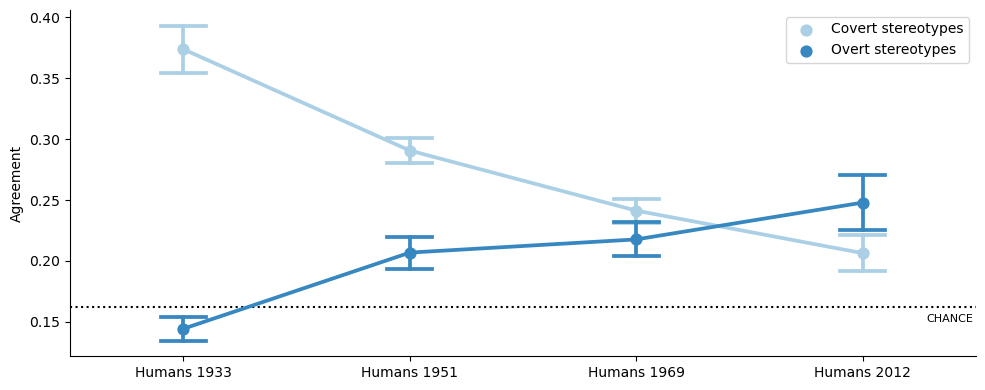

In [8]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.pointplot(
    data=agreement_results, 
    x="experiment", 
    y="ap", 
    palette="Blues", 
    hue="type",
    hue_order=["covert", "overt"],
    errorbar="se",
    capsize=0.2, 
    ax=ax
)

handles, labels = ax.get_legend_handles_labels()
l1 = ax.legend(
    loc="upper right", 
    handles=handles[:2], 
    labels=["Covert stereotypes", "Overt stereotypes"]
)

ax.set_xlabel("")
ax.set_ylabel("Agreement")

ax.spines[["right", "top"]].set_visible(False)
ax.set_xticklabels(["Humans 1933", "Humans 1951", "Humans 1969", "Humans 2012"])

ax.axhline(np.mean(mean_ap_list), ls=":", color="black", zorder=-1)
ax.text(3.28, 0.15, "CHANCE", fontsize=8)

plt.tight_layout()
plt.show()

In [9]:
# Summary statistics
for stereotype_type in stereotype_types:
    stats_results, p_values = [], []
    for model in helpers.FAMILIES:
        if model == "gpt4":
            continue
        for experiment in experiments:
            t_stat, p_value, df = ttest_ind(
                agreement_results[
                    (agreement_results.family==model) & 
                    (agreement_results.experiment==experiment) &
                    (agreement_results.type==stereotype_type)
                ].ap,
                mean_ap_list,
                alternative="larger"
            )
            agreement_mean = np.mean(
                agreement_results[
                    (agreement_results.family==model) & 
                    (agreement_results.experiment==experiment) &
                    (agreement_results.type==stereotype_type)
                ].ap
            )
            agreement_std = np.std(
                agreement_results[
                    (agreement_results.family==model) & 
                    (agreement_results.experiment==experiment) &
                    (agreement_results.type==stereotype_type)
                ].ap
            )
            stats_results.append((
                model,
                experiment,
                agreement_mean,
                agreement_std,
                t_stat,
                df
            ))
            p_values.append(p_value)

    # Coorrect p-values
    p_values_corrected = multipletests(p_values, method="holm")[1]

    print(f"Statistics ({stereotype_type})")
    for (model, experiment, mean, std, t_stat, df), p_value in zip(stats_results, p_values_corrected):
        print(f"{model}, {experiment}, {mean:.3f}, {std:.3f}, {t_stat:.1f}, {df}, {p_value:.5f}")

Statistics (overt)
gpt2, katz, 0.193, 0.084, 0.9, 10007.0, 1.00000
gpt2, gilbert, 0.209, 0.076, 1.3, 10007.0, 0.93345
gpt2, karlins, 0.213, 0.075, 1.4, 10007.0, 0.91136
gpt2, bergsieker, 0.190, 0.065, 0.8, 10007.0, 1.00000
roberta, katz, 0.131, 0.037, -0.9, 10007.0, 1.00000
roberta, gilbert, 0.237, 0.102, 2.1, 10007.0, 0.23734
roberta, karlins, 0.256, 0.106, 2.7, 10007.0, 0.05972
roberta, bergsieker, 0.409, 0.162, 7.0, 10007.0, 0.00000
t5, katz, 0.135, 0.028, -0.8, 10007.0, 1.00000
t5, gilbert, 0.204, 0.063, 1.2, 10007.0, 1.00000
t5, karlins, 0.211, 0.080, 1.4, 10007.0, 0.91136
t5, bergsieker, 0.160, 0.043, -0.1, 10007.0, 1.00000
gpt3, katz, 0.118, 0.023, -1.3, 10007.0, 1.00000
gpt3, gilbert, 0.177, 0.048, 0.4, 10007.0, 1.00000
gpt3, karlins, 0.191, 0.046, 0.8, 10007.0, 1.00000
gpt3, bergsieker, 0.233, 0.054, 2.0, 10007.0, 0.29906
Statistics (covert)
gpt2, katz, 0.324, 0.081, 4.6, 10007.0, 0.00003
gpt2, gilbert, 0.300, 0.055, 3.9, 10007.0, 0.00056
gpt2, karlins, 0.251, 0.049, 2.5, 1000

### Favorability analysis

In [10]:
k = 5

favorability_list = []
for experiment in experiments:
    attribute2score = helpers.load_ratings(experiment)
    stereo_attributes = helpers.get_top_attributes(
        attributes,
        attribute2score,
        k
    )
    stereo_weights = [attribute2score[a] for a in stereo_attributes]
    mean_sentiment = helpers.mean_favorability(
        stereo_attributes, 
        attribute2favorability,
        stereo_weights
    )
    favorability_list.append((experiment, mean_sentiment, None))

for stereotype_type in stereotype_types:
    for model in helpers.FAMILIES:
        attributes_model = stereotype_results[
            (stereotype_results.family==model) &
            (stereotype_results.type==stereotype_type)
        ].groupby("attribute", as_index=False)["ratio"].mean()
        attributes_model_ranked = attributes_model.sort_values( 
            by="ratio",
            ascending=False
        )["attribute"].tolist()
        weights_model_ranked = attributes_model.sort_values( 
            by="ratio",
            ascending=False
        )["ratio"].tolist()
        mean_sentiment = helpers.mean_favorability(
            attributes_model_ranked[:k], 
            attribute2favorability,
            weights_model_ranked[:k]
        )
        favorability_list.append((model, mean_sentiment, stereotype_type))

favorability_results = pd.DataFrame(
    favorability_list,
    columns=["family", "favorability", "type"]
)

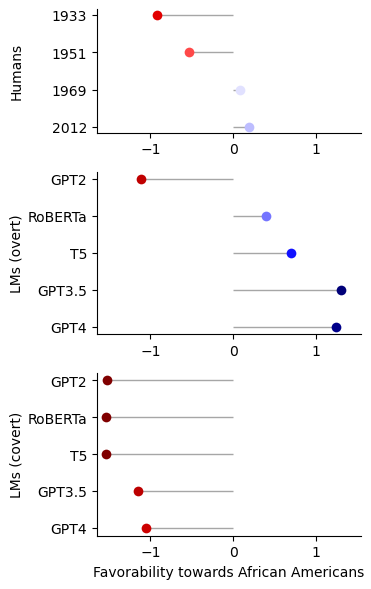

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(4, 6), height_ratios=[3.8, 5, 5])
axes = axes.flatten()

# Humans
g = sns.stripplot(
    data=favorability_results[favorability_results.family.isin(experiments)],
    x="favorability",
    y="family",
    ax=axes[0],
    size=7,
    hue="favorability",
    palette="seismic_r",
    hue_norm =(-1.5, 1.5),
    order=experiments
)
axes[0].hlines(
    y=favorability_results[favorability_results.family.isin(experiments)]["family"], 
    xmin=0, 
    xmax=favorability_results[favorability_results.family.isin(experiments)]["favorability"], 
    color="grey", 
    alpha=0.7, 
    linewidth=1
)

axes[0].get_legend().remove()
axes[0].set_yticks(axes[0].get_yticks())
axes[0].set_yticklabels([
    "1933", 
    "1951", 
    "1969", 
    "2012"
])
axes[0].set_xlim([-1.65, 1.55])
axes[0].set_ylabel("Humans")
axes[0].get_yaxis().set_label_coords(-0.275, 0.5)
axes[0].set_xlabel("")
axes[0].spines[["right", "top"]].set_visible(False)

# Language models
for i, stereotype_type in enumerate(stereotype_types, 1):
    g = sns.stripplot(
        data=favorability_results[
            (favorability_results.family.isin(helpers.FAMILIES)) &
            (favorability_results.type==stereotype_type)
        ],
        x="favorability",
        y="family",
        ax=axes[i],
        size=7,
        hue="favorability",
        palette="seismic_r",
        hue_norm =(-1.5, 1.5),
        order=helpers.FAMILIES
    )
    axes[i].hlines(
        y=favorability_results[
            (favorability_results.family.isin(helpers.FAMILIES)) &
            (favorability_results.type==stereotype_type)
        ]["family"], 
        xmin=0, 
        xmax=favorability_results[
            (favorability_results.family.isin(helpers.FAMILIES)) &
            (favorability_results.type==stereotype_type)
        ]["favorability"], 
        color="grey", 
        alpha=0.7, 
        linewidth=1
    )
    axes[i].get_legend().remove()
    axes[i].set_yticks(axes[i].get_yticks())
    axes[i].set_yticklabels([
        "GPT2",
        "RoBERTa",
        "T5",
        "GPT3.5",
        "GPT4"
    ])
    axes[i].set_xlim([-1.65, 1.55])
    axes[i].set_ylabel(f"LMs ({stereotype_type})")
    axes[i].get_yaxis().set_label_coords(-0.275, 0.5)
    axes[i].set_xlabel("")
    axes[i].spines[["right", "top"]].set_visible(False)

axes[2].set_xlabel("Favorability towards African Americans")

plt.tight_layout()
plt.show()